# **FRAUD DETECTION AND RISK ANALYSIS**

In [18]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

In [19]:
# Loading dataset
df = pd.read_csv("fraud_dataset.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,14-08-2023 19:30,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,07-06-2023 04:01,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,20-06-2023 15:25,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,07-12-2023 00:31,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,11-11-2023 23:44,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [20]:
# Missing values & duplicates
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

# Statistics
df.describe()

# Categorical distribution
df["Transaction_Type"].value_counts()


Missing Values:
 Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64

Duplicate Rows: 0


POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: Transaction_Type, dtype: int64

**Data cleaning**

In [21]:
# Convert timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Handle missing + duplicates
df.fillna(method="ffill", inplace=True)
df.drop_duplicates(inplace=True)

# Remove invalid amounts
df = df[df["Transaction_Amount"] >= 0]

cleaned_data = df.copy()


**Fraud Distribution**

0    67.866
1    32.134
Name: Fraud_Label, dtype: float64


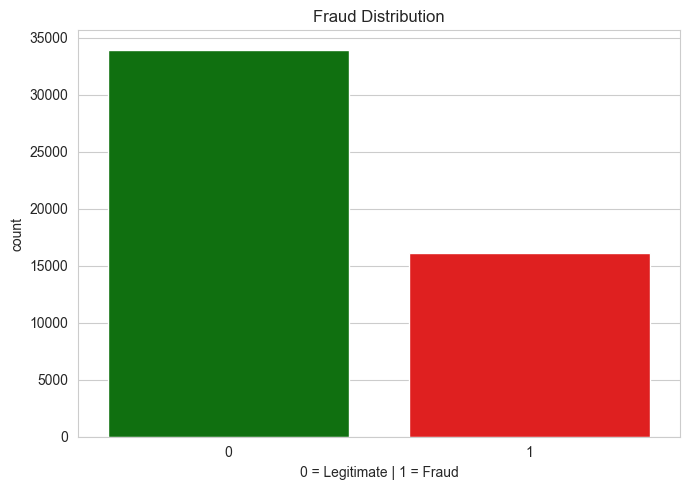

In [22]:
# Fraud percentage
fraud_pct = df["Fraud_Label"].value_counts(normalize=True) * 100
print(fraud_pct)

# Visualization
plt.figure(figsize=(7,5))
sns.countplot(x="Fraud_Label", data=df, palette=["green","red"])
plt.title("Fraud Distribution")
plt.xlabel("0 = Legitimate | 1 = Fraud")
plt.tight_layout()
plt.show()

**Time Feature Engineering**

In [23]:
# Extract time features
time_cols = {
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Hour": "hour",
    "DayOfWeek": "dayofweek",
    "DayName": "day_name"
}

for col, attr in time_cols.items():
    cleaned_data[col] = getattr(cleaned_data["Timestamp"].dt, attr)


In [24]:
# Odd hour transactions (2 AM – 5 AM)
cleaned_data["Is_Odd_Hours"] = cleaned_data["Hour"].between(2,5).astype(int)

print("✓ Time Features Created")


✓ Time Features Created


**Fraud Analysis by Categories**

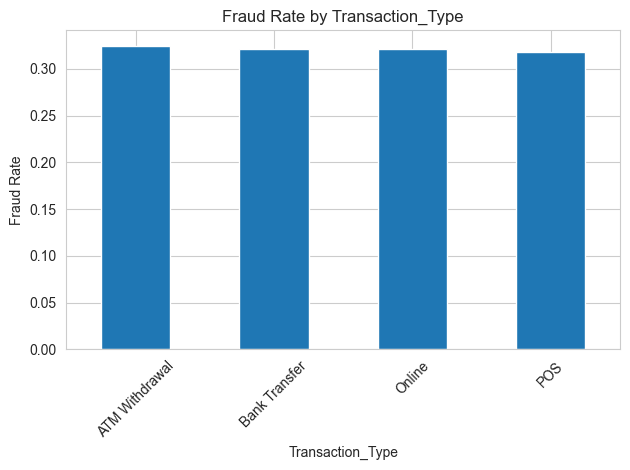

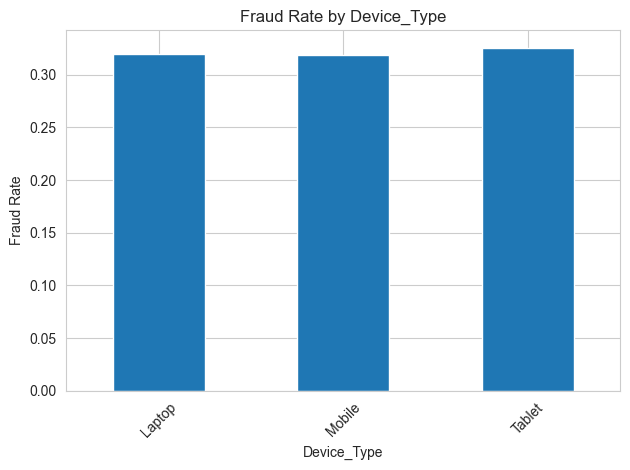

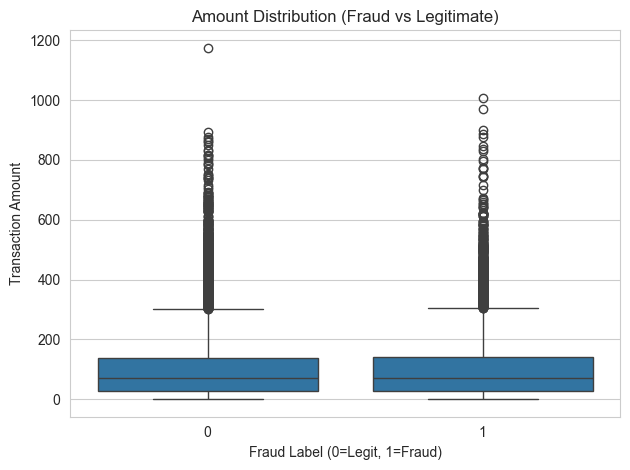

In [25]:
def fraud_rate_plot(column):
    rate = cleaned_data.groupby(column)["Fraud_Label"].mean()
    rate.plot(kind="bar", title=f"Fraud Rate by {column}")
    plt.ylabel("Fraud Rate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

fraud_rate_plot("Transaction_Type")
fraud_rate_plot("Device_Type")

# Amount distribution (Fraud vs Legitimate)
sns.boxplot(x='Fraud_Label', y='Transaction_Amount', data=cleaned_data)
plt.title('Amount Distribution (Fraud vs Legitimate)')
plt.xlabel('Fraud Label (0=Legit, 1=Fraud)')
plt.ylabel('Transaction Amount')
plt.tight_layout()
plt.show()

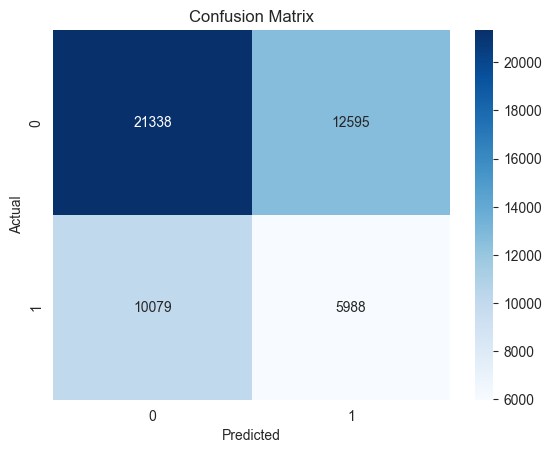

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# simple rule-based prediction
y_true = df['Fraud_Label']
y_pred = (df['Transaction_Amount'] > df['Transaction_Amount'].mean()).astype(int)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Fraud Flags**

In [27]:
cleaned_data["High_Value_Flag"] = (cleaned_data["Transaction_Amount"] > 200).astype(int)
cleaned_data["Round_Amount_Flag"] = (cleaned_data["Transaction_Amount"] % 10 == 0).astype(int)
cleaned_data["High_Frequency_Flag"] = (cleaned_data["Daily_Transaction_Count"] > 10).astype(int)
cleaned_data["High_Failure_Flag"] = (cleaned_data["Failed_Transaction_Count_7d"] > 3).astype(int)

# Total flags
flag_cols = [c for c in cleaned_data.columns if "Flag" in c]
cleaned_data["Total_Fraud_Flags"] = cleaned_data[flag_cols].sum(axis=1)


**Risk Score**

In [28]:
def calculate_risk(row):
    return (
        min(row.Transaction_Amount/500,1)*0.25 +
        (row.Total_Fraud_Flags/8)*0.25 +
        min(row.Failed_Transaction_Count_7d/10,1)*0.2 +
        min(row.Transaction_Distance/5000,1)*0.2 +
        (row.Hour/24)*0.1
    )

cleaned_data["Risk_Score"] = cleaned_data.apply(calculate_risk, axis=1)


**Operational Analysis**

In [29]:
print("\n📊 OPERATIONAL ANALYSIS\n" + "="*60)

# 1. Failed transaction analysis
print("\n[1] Failed Transactions:")
total_failed = cleaned_data['Failed_Transaction_Count_7d'].sum()
print(f"  Total Failed: {total_failed:,.0f}")

fraud_failed = cleaned_data[cleaned_data['Fraud_Label'] == 1]['Failed_Transaction_Count_7d'].mean()
legit_failed = cleaned_data[cleaned_data['Fraud_Label'] == 0]['Failed_Transaction_Count_7d'].mean()
print(f"  Avg Failed (Fraud users): {fraud_failed:.2f}")
print(f"  Avg Failed (Legit users): {legit_failed:.2f}")

# 4. Cost calculation
print("\n[2] Operational Costs:")
fraud_amount = cleaned_data[cleaned_data['Fraud_Label'] == 1]['Transaction_Amount'].sum()
total_amount = cleaned_data['Transaction_Amount'].sum()
# Time loss cost (5 min per failed transaction, $50/hour labor)
time_cost = (total_failed * 5 / 60) * 50

print(f"  Total Fraud Amount: ${fraud_amount:,.2f}")
print(f"  Failed Transaction Cost: ${time_cost:,.2f}")
print(f"  Total Loss: ${fraud_amount + time_cost:,.2f}")



📊 OPERATIONAL ANALYSIS

[1] Failed Transactions:
  Total Failed: 100,177
  Avg Failed (Fraud users): 3.05
  Avg Failed (Legit users): 1.51

[2] Operational Costs:
  Total Fraud Amount: $1,601,617.65
  Failed Transaction Cost: $417,404.17
  Total Loss: $2,019,021.82


**Correlation Heatmap**

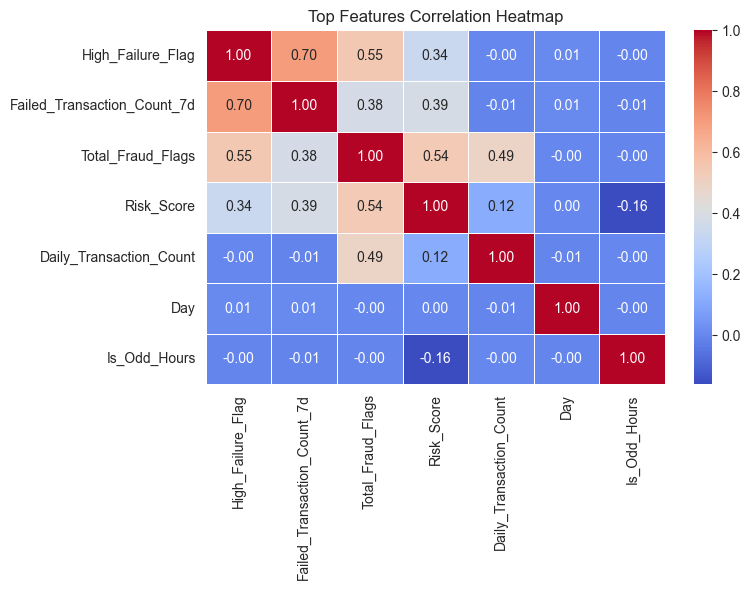

In [30]:
corr = cleaned_data.corr(numeric_only=True)

top_features = corr['Fraud_Label'].abs().sort_values(ascending=False)[1:8].index

plt.figure(figsize=(8,6))
sns.heatmap(cleaned_data[top_features].corr(), 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f",
            linewidths=0.5)

plt.title("Top Features Correlation Heatmap")
plt.tight_layout()
plt.show()


**Saving & Exporting Data**

In [31]:
# Save outputs
cleaned_data.to_csv("cleaned_fraud_data.csv", index=False)

cleaned_data[
    ["Fraud_Label","High_Value_Flag","Round_Amount_Flag",
     "Total_Fraud_Flags","Risk_Score"]
].to_csv("fraud_flags.csv", index=False)

cleaned_data.describe().to_csv("summary_statistics.csv")

print("✓ All outputs saved successfully")


✓ All outputs saved successfully


# MYSQL CONNECTION

In [32]:
!pip install mysql-connector-python sqlalchemy pymysql


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from sqlalchemy import create_engine

username = "root"
password = "7272"
host = "localhost"
port = "3306"
database = "fraud_detection_analysis"

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

df.to_sql("fraud_detection_analysis", engine, if_exists="replace", index=False)

print("Cleaned data successfully uploaded to MySQL!")

Cleaned data successfully uploaded to MySQL!
